In [ ]:
import pandas as pd
import keras
import os
from data_loading import load_tracking_data
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy import spatial
import numpy as np
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


from utility_db_25 import mark_columns, TrainML
from utility_db_25 import mark_columns, TrainML, get_momentum_cols, create_momentum_index, get_motion_cols, motion_complexity_score
root_dir = os.getcwd()

# Load data

We first load our data, starting with tracking & general player data

In [4]:
# load tracking data for all weeks
root_dir = os.getcwd()
tracking_fname_list = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,10)]
df_tracking = pd.concat(
        [load_tracking_data(tracking_fname) for tracking_fname in tracking_fname_list]
    )

# get players data
df_players = pd.read_csv(os.path.join(root_dir,'data/players.csv'))

# load tracking, truncate to relevant columns, delete
cols_track = ['gameId','playId','nflId','frameId','club','x_standard','y_standard']
track_trunc = df_tracking[cols_track]
del(df_tracking)

### Merge onto play level

Note: some plays (38?) lack defensive tracking data, ergo losing some plays to dropping NA's 


In [5]:
# merge (defensive) tracking info to play-level data
df_plays = pd.read_csv(os.path.join(root_dir,'data/plays.csv'))
play_trunc = df_plays[['gameId','playId','defensiveTeam','isDropback']]
pt_df = play_trunc.merge(track_trunc,how='left',left_on=['gameId','playId','defensiveTeam'],
                 right_on=['gameId','playId','club'])

# na's dropped to lose players w/o tracking info
def_df = pt_df.dropna().copy()
def_df.head(3)

,gameId,playId,defensiveTeam,isDropback,nflId,frameId,club,x_standard,y_standard
0,2022102302,2655,ATL,True,46091.0,1.0,ATL,36.76,25.32
1,2022102302,2655,ATL,True,46091.0,2.0,ATL,36.78,25.37
2,2022102302,2655,ATL,True,46091.0,3.0,ATL,36.79,25.43


### Calculate per-frame pairwise distance 

Excluding D-linemen, we get the mean pairwise distance between defensive players at each timestamp

In [6]:
# get position here for calcs
def_temp = def_df.merge(df_players[['nflId','position','weight']],how='left',copy=False)
def_temp.sort_values(by=['gameId','playId','frameId'],inplace=True)
del(track_trunc)
del(df_players)
def_temp.head()

,gameId,playId,defensiveTeam,isDropback,nflId,frameId,club,x_standard,y_standard,position,weight
15239158,2022090800,56,LA,True,38577.0,2.0,LA,38.17,24.743333,ILB,242
15239302,2022090800,56,LA,True,41239.0,2.0,LA,37.15,23.443333,DT,280
15239446,2022090800,56,LA,True,42816.0,2.0,LA,38.03,28.823333,CB,184
15239590,2022090800,56,LA,True,43294.0,2.0,LA,38.46,20.543333,CB,208
15239734,2022090800,56,LA,True,43298.0,2.0,LA,36.97,20.623333,DE,240


In [7]:
# get mean pairwise distance between each player in x, y, and overall directions, excluding DL who mess with things
pw_total =def_temp[~def_temp.position.isin(['DE','DT','NT'])].groupby(['gameId','playId','frameId']).apply(lambda x: spatial.distance.pdist(np.array(list(zip(x.x_standard, x.y_standard)))).mean()).reset_index().rename(columns={0:'mean_pairwise_dist'})
pw_total.head()

,gameId,playId,frameId,mean_pairwise_dist
0,2022090800,56,2.0,4.343352
1,2022090800,56,3.0,4.477294
2,2022090800,56,4.0,4.612491
3,2022090800,56,5.0,4.740826
4,2022090800,56,6.0,4.874704


### Get uniform # of frames

We bound each play to 200 frames to make it easier on our model, using a cartesian product to merge into

In [8]:
# merge pairwise dist data back in
ci = pd.merge(pw_total[['gameId','playId']].drop_duplicates(), pd.Series(list(range(1,201))).rename('frameId'), how='cross',copy=False).sort_values(by=['gameId','playId','frameId'])
ci_merged = ci.merge(pw_total,how='left',copy=False)

# zero-fill for masking reasons
ci_merged = ci_merged.fillna(0)

# merge back in
db_df = def_df[['gameId','playId','isDropback']].drop_duplicates()
ci_pre = ci_merged.merge(db_df,how='left')

### Perform train/test split

We integrate week data, then subset based on week 9 holdout:

In [9]:
df_games = pd.read_csv('data/games.csv')[[
    'gameId','week'
]].drop_duplicates()
ci_out = ci_pre.merge(df_games)
ci_out.head(3)

,gameId,playId,frameId,mean_pairwise_dist,isDropback,week
0,2022090800,56,1,0.000000,True,1
1,2022090800,56,2,4.343352,True,1
2,2022090800,56,3,4.477294,True,1


In [10]:
# subset week
df_train = ci_out[ci_out['week'] <9].copy()
df_test = ci_out[ci_out['week'] ==9].copy()

# y = isDropback
y_train = df_train.drop_duplicates(subset=['gameId','playId'])['isDropback'].astype(int)
y_test = df_test.drop_duplicates(subset=['gameId','playId'])['isDropback'].astype(int)

### Scale data, then reshape for RNN:

In [11]:
# define scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# scale
df_train['mean_pairwise_dist'] = scaler.fit_transform(df_train['mean_pairwise_dist'].values.reshape(-1, 1))
df_test['mean_pairwise_dist'] = scaler.transform(df_test['mean_pairwise_dist'].values.reshape(-1, 1))

# reshape
X_train = df_train['mean_pairwise_dist'].to_numpy().reshape(int(len(df_train)/200), 200, 1)
X_test = df_test['mean_pairwise_dist'].to_numpy().reshape(int(len(df_test)/200), 200, 1)

### Build single-feature LSTM

We build a single-feature LSTM on 'mean_pairwise_dist', i.e., the mean distance between players for a frame

In [12]:
# Define model architecture

def create_RNN(hidden_units, dense_units, activation):
    model = keras.models.Sequential()
    model.add(keras.layers.Masking(mask_value=0.))
    model.add(keras.layers.LSTM(128))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(.005))
    model.add(Dense(8, activation='tanh'))
    model.add(Dropout(.005))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam(.004)

    return model

Above we define architecture; below we build our single-feaure model

In [13]:
demo_model = create_RNN(10, 1, activation=['linear', 'linear'])
demo_model.compile(loss='binary_crossentropy')
demo_model.fit(X_train,y_train,epochs=10)
y_pred = (demo_model.predict(X_test) > .5)
sum(y_test == y_pred.reshape(-1))

Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - loss: 0.6406
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - loss: 0.6142
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - loss: 0.6125
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 43s 95ms/step - loss: 0.6138
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - loss: 0.6112
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 45s 98ms/step - loss: 0.6094
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 54s 117ms/step - loss: 0.6032
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 55s 122ms/step - loss: 0.6142
Epoch 9/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - loss: 0.6145
Epoch 10/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.6089
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


1027

Get accuracy, prediction label balance:

In [14]:
pd.Series(y_pred.reshape(-1)).value_counts()

True     1139
False     391
dtype: int64

In [15]:
sum(y_test == y_pred.reshape(-1))/1530

0.6712418300653594

### Run test example:

We pick a semi-arbitrary frame to demonstrate changing predictions:

In [17]:
test_example = df_test[(df_test['gameId'] == 2022110300) & (df_test['playId'] == 55)]
pred_ls = []
for i in range(len(test_example)):
    ca = test_example['mean_pairwise_dist'][:i+1].values
    cac = np.concatenate((ca,np.zeros(len(test_example)-(i+1))),axis=0)
    cr = cac.reshape(1,200,1)
    pred_ls.append(demo_model.predict(cr)[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━

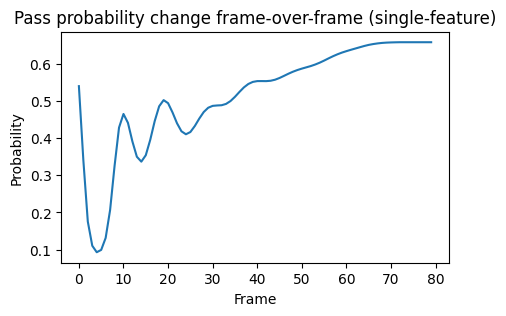

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Pass probability change frame-over-frame (single-feature)')
plt.xlabel('Frame')
plt.ylabel('Probability')
plt.plot(pred_ls[:80])
plt.show()

# Try LSTM w/static data added:

We keep our dynamic pairwise-distance feature, while also adding some static features:

In [30]:
# load original data
train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))

# subset to static features that likely won't peek
train_sub = df_train.merge(train_data[['gameId','playId','off_xpass','xpass_situational','n_offense_backfield']],how='left')
test_sub = df_test.merge(test_data[['gameId','playId','off_xpass','xpass_situational','n_offense_backfield']],how='left')

#reshape for model
X_train= train_sub[['mean_pairwise_dist','off_xpass','xpass_situational','n_offense_backfield']].values.reshape(int(len(df_train)/200),200,4)
X_test = test_sub[['mean_pairwise_dist','off_xpass','xpass_situational','n_offense_backfield']].values.reshape(int(len(df_test)/200),200,4)

Create static-inclusive model:

In [32]:
model_w_static = create_RNN(10, 1, activation=['linear', 'linear'])
model_w_static.compile(loss='binary_crossentropy')
model_w_static.fit(X_train,y_train,epochs=10)
y_pred = (model_w_static.predict(X_test) > .5)

Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 63s 135ms/step - loss: 0.5587
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - loss: 0.5197
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 59s 130ms/step - loss: 0.5215
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 63s 138ms/step - loss: 0.5203
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 58s 127ms/step - loss: 0.5126
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 57s 126ms/step - loss: 0.5146
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 55s 120ms/step - loss: 0.5195
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 52s 114ms/step - loss: 0.5208
Epoch 9/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 55s 121ms/step - loss: 0.5159
Epoch 10/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - loss: 0.5173
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
accuracy is: 0.7372549019607844


We see improved accuracy——better than the xpass_situational-only model (around .7)——by adding these feats:

In [33]:
print(f'accuracy is: {sum(y_test == y_pred.reshape(-1))/1530}')

accuracy is: 0.7372549019607844


# Try combining w/ LGBM:

We see if this new model, blended with an LGBM, yields results. First we do boilerplate cleaning:

In [34]:
imputer = SimpleImputer(strategy='mean')

include_columns=[x for x in test_data.columns if '_def' not in x]+['pass_rate_def']
train_data =train_data[include_columns]
test_data = test_data[include_columns]

motion_cols=get_motion_cols(train_data.columns)
momentum_cols=get_momentum_cols(train_data.columns)


train_data=create_momentum_index(train_data, momentum_cols)
test_data=create_momentum_index(test_data, momentum_cols)

train_data=motion_complexity_score(train_data, motion_cols)
test_data=motion_complexity_score(test_data, motion_cols)

### Define features, match indices

We make sure our indices align, and that we have no feature overlap with our previous static-fed model:

In [35]:
# define features
final_features=['pass', 'QB_RB1_offset', 'db_ct', 'QBdffy_RB', #'QBdff_T',
        'motion-momentum',  'n_offense_backfield',  'neg_Formations']

#align indices
train_sub = train_data.merge(df_train[['gameId','playId']].drop_duplicates(),how='inner')
test_sub = test_data.merge(df_test[['gameId','playId']].drop_duplicates(),how='inner')

# get column cat. vs numeric info
numeric_columns, cat_columns = mark_columns(df=train_sub,features=final_features, nc=None,cc = None)

# define x/y
X=train_sub[final_features].drop(columns='pass')
y=train_sub['pass']

### Build LGBM

We train the model:

Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]

Mean Train AUC --> 0.7739
Mean Validation AUC ---> 0.7346
Mean Train Accuracy --> 0.7929
Mean Validation Accuracy ---> 0.7553


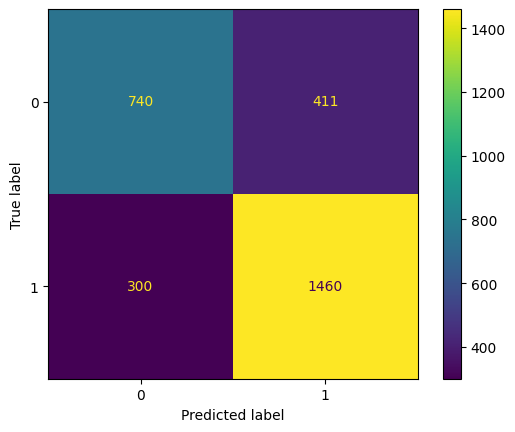

In [36]:
#lgbm classifier
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, numeric_columns),('scaler', MinMaxScaler(), numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)
pipeline=Pipeline([('tr', transformer), ('lgbm', LGBMClassifier(verbosity=-1))], verbose = True)
lgb = LGBMClassifier(verbosity=-1,seed=42).fit(X,y)
TrainML(pipeline,X, y,5,SEED=42)

### Combine predictions:

In [38]:
rnn_preds = model_w_static.predict(X_test)
lgb_preds = [x[1] for x in lgb.predict_proba(test_sub[final_features].drop(columns=['pass'],inplace=False))]

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


In [40]:
lgb_correct = sum(lgb.predict(test_sub[final_features].drop(columns=['pass'],inplace=False)) == y_test)

In [41]:
print(f'lgb accuracy is: {lgb_correct/1530}')

lgb accuracy is: 0.7816993464052288


In [53]:
print(f'rnn accuracy is: {sum((rnn_preds > .5).reshape(-1,) == y_test)/1530}')

rnn accuracy is: 0.7372549019607844


In [61]:
comb_preds = (.2 * rnn_preds.reshape(-1,)  + .8 * np.asarray(lgb_preds))

## Results summary

We see a marginal increase if we lightly weigh the RNN, and strongly weigh the LGBM. 

However, this is worse than our peak, and the worse LGBM-only performance is likely from losing static features to the RNN.

In [63]:
print(f'Combined accuracy is: {sum((comb_preds > .5) == y_test)/1530}')

Combined accuracy is: 0.792156862745098
